In [ ]:
import nest_asyncio
nest_asyncio.apply()

import numpy as np
import stan
import matplotlib.pyplot as plt

import arviz as az

In [ ]:
model = """
data {
   int N; // Number of data points
   int P; // Number of sums
   matrix[N,P] x;   
   vector[N] y; 
}

transformed data {
    // Create new variables/auxiliary variables from the data
    vector[P] bb = rep_vector(1.0,P) ;
}
parameters {
   real alpha;     // intercept
   real<lower=0> eps;       // dispersion
}
model {
    y ~ normal(x * bb - alpha, eps);
}"""

model_0 = """
data {
   int N; // Number of data points
   vector[N] x;  
   vector[N] y;      // the 2nd predictor
}
parameters {
   real alpha;     // intercept
   real<lower=0> eps;       // dispersion
}
model {
    y ~ normal(x - alpha, eps);
}"""

model_1 = """
data {
   int N; // Number of data points
   int P; // Number of sums
   vector[P*2] x[N];   
   vector[N] y; 
}

parameters {
   real alpha;     // intercept
   real<lower=0> eps;       // dispersion
}
model {
   for (ii in 1:N)
      y[ii] ~ normal(sum(x[ii]) - alpha, eps);
}"""

In [ ]:
N = 20;
x = np.random.randn(N)
y = x + 1.2 + np.random.randn(N)*0.2
data = {'N':N, 'x':x, 'y':y, 'extra' : 1}
posterior = stan.build(model_0, data=data, random_seed=1)
fit = posterior.sample(num_chains=4, num_samples=1000)

In [ ]:
N = 20;
P = 2;
x = np.random.randn(N,P*2)
y = x.sum(axis=1) + 1.2 + np.random.randn(N)*0.2
data = {'N':N, 'P' : P, 'x':x, 'y':y}
posterior = stan.build(model_1, data=data, random_seed=1)
fit2 = posterior.sample(num_chains=4, num_samples=1000)

In [ ]:
plt.plot(fit2["alpha"][0,:]);

az.summary(fit2)


In [ ]:
model_0 = """
data {
   int N; // Number of data points
   int T; // max time per observation
   int Y[N]
   int session[N]
   int subject[N]
   int time_index[N]
   vector[N] is_same_context_1[T]
   vector[N] is_same_1_back[T]
}
transformed data {
   vector[N] is_same_observation[N];
   for (aa in 1:N)
      for (bb in 1:N)
         if(bb < aa && Y[aa] == Y[bb])
            is_same_observation[aa,bb] = 1
         else
            is_same_observation[aa,bb] = 0
}
parameters {
   real alpha;     // intercept
   real<lower=0> eps;       // dispersion
}
model {
    y ~ normal(x - alpha, eps);
}"""

In [ ]:
model_ddcrp_simplified1 = """
data {
    int N; // Number of data points
    int M; // number of possible observations
    array[N] int Y;
    matrix[N,N] is_same_context_1;
    matrix[N,N] is_same_1_back;
}
transformed data {
    // variables to turn main computation in matrix operations
    matrix[N,N] is_same_observation;
    matrix[N,N] is_prev_observation;
    matrix[N,N] is_different_context_1;
    matrix[N,N] deltas;
    for (aa in 1:N) {
        for (bb in 1:N) {
            if(bb < aa) {
                deltas[aa,bb] = aa-bb;
                is_prev_observation[aa,bb] = 1;
            }
            else {
                deltas[aa,bb] = 1;
                is_prev_observation[aa,bb] = 0;
            }
            if(bb < aa && Y[aa] == Y[bb]) {
                is_same_observation[aa,bb] = 1;
            }
            else {
                is_same_observation[aa,bb] = 0;
            }
            
            if(bb < aa && is_same_context_1[aa,bb] <= 0) {
                is_different_context_1[aa,bb] = 1;
            }
            else {
                is_different_context_1[aa,bb] = 0;
            }
        }
    }

    vector[N] Y_is_same_as_one_back = rep_vector(0, N);
    for (aa in 2:N) {
        if(Y[aa] == Y[aa-1]) {
            Y_is_same_as_one_back[aa] = 1;
        }
    }
    // vector[N] log_BaseMeasure = rep_vector(-log(M),N) ;
    
    vector[N] vs = rep_vector(1.0,N) ;
    array[N] int vi ;
    for (aa in 1:N) {
        vi[aa] = 1;
    }
    
}
parameters {
    real<lower=0,upper=1> scale_different_context_1;    
    real<lower=0> scale_same_1_back;      
    real<lower=0> alpha ;
    real<lower=0> timescale_within_session;      
}
transformed parameters {
    real<upper=0> log_scale_different_context_1;    
    real log_scale_same_1_back;      
    // real log_alpha
    log_scale_different_context_1 = log(scale_different_context_1);
    log_scale_same_1_back = log(scale_same_1_back);
}
model {
    matrix[N,N] weights_same_obs;
    matrix[N,N] weights_all_obs;
    vector[N] ps;
    vector[N] aa;
    vector[N] BaseMeasure;
    
    alpha ~ gamma(2, 1.0/5);
    timescale_within_session ~ gamma(2.0, 1.0/25);
    scale_different_context_1 ~ beta(1.0, 1.0);
    scale_same_1_back ~ gamma(20, 20);

    
    BaseMeasure = ((scale_same_1_back-1) * Y_is_same_as_one_back + 1) / (scale_same_1_back + (M-1));


    weights_all_obs = is_prev_observation  .* exp(-deltas/timescale_within_session + log_scale_different_context_1 *  is_different_context_1 + log_scale_same_1_back * is_same_1_back);
    weights_same_obs  = is_same_observation .* weights_all_obs[:,1:N];

    // probability of drawing the observed observations given their pasts
    ps =  ((weights_same_obs * vs) + (alpha*BaseMeasure)) ./  ((weights_all_obs * vs) + (alpha));

    vi ~ bernoulli(ps); // note: not generative - this is a simplified distribution to make the log likelihood computations work quickly in Stan
}"""

In [79]:
Y = np.random.randint(1,3, size=(50))#np.array([1, 2, 2, 1, 1, 2, 2, 2, 1, ])

N = Y.size
M = 2;

is_same_context_1 = np.zeros((N,N),dtype=int)
is_same_1_back = np.zeros((N,N),dtype=int)
for ii in range(1,N):
    for jj in range(1,ii):
        if(Y[jj-1] == Y[ii-1]):
            is_same_context_1[ii,jj] = 1
        if(Y[jj] == Y[ii-1]):
            is_same_1_back[ii,jj] = 1

In [80]:
data = {"N" : N, "M" : M, "Y" : Y, "is_same_context_1" : is_same_context_1, "is_same_1_back" : is_same_1_back}
posterior = stan.build(model_ddcrp_simplified1, data=data, random_seed=1)
fit = posterior.sample(num_chains=4, num_samples=1000)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_m5jhvz8q/model_awkvgahy.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_m5jhvz8q/model_awkvgahy.stan', line 50, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_m5jhvz8q/model_awkvgahy.stan', line 79, column 34: Argument
    20 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_m5jhvz8q/model_awkvgahy.stan', line 79, column 30: Argum

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
scale_different_context_1,0.539,0.276,0.091,1.000,0.004,0.003,3793.0,2363.0,1.0
scale_same_1_back,0.972,0.147,0.687,1.235,0.002,0.002,4151.0,2230.0,1.0
alpha,12.097,7.235,1.264,25.646,0.110,0.080,3742.0,2503.0,1.0
timescale_within_session,51.341,36.116,3.847,118.965,0.562,0.405,3112.0,1840.0,1.0
log_scale_different_context_1,-0.851,0.863,-2.398,-0.000,0.018,0.016,3793.0,2363.0,1.0
log_scale_same_1_back,-0.040,0.152,-0.330,0.241,0.002,0.002,4151.0,2230.0,1.0


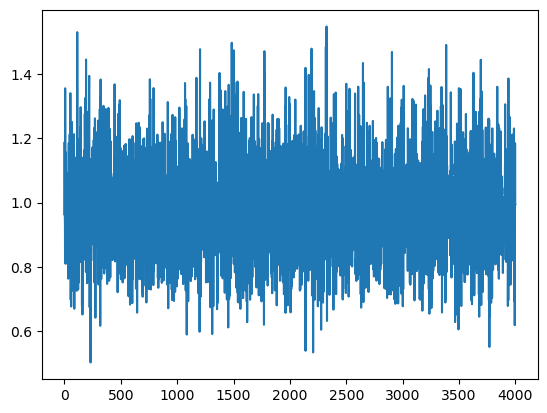

In [ ]:
plt.plot(fit["scale_same_1_back"].flatten())
az.summary(fit)